# Meteorite Landings Viewer

### <font color='B43F26'> Descripción </font>
***

<div class="alert alert-block alert-info">

## Inputs:

The information used for this example is:
    
    -[Kaggle]meteorite_landings.zip

## Output:

The results can be stored/showed in:

    -matplotlib interactive
    -geo2kml.kml

In [1]:
import pandas as pd

import geopandas
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors

#IPython
from IPython.core.magic import register_cell_magic
#download link
from IPython.display import FileLink

In [2]:
#Debug
DEBUG = True

#File path
zip_file_path = "zip://example_datasets/[Kaggle]meteorite_landings.zip"

## Load Dataset 

In [3]:
#Load zip to a data frame
meteorites_df = geopandas.read_file(zip_file_path)

#Clean coordinates information to be able to turn the DataFrame into a geoDataFrame
meteorites_df.reclong.replace({"None": "0", "nan": "0", "": "0"}, inplace=True)
meteorites_df.reclat.replace({"None": "0", "nan": "0", "": "0"}, inplace=True)

#Discard rows wqith "0" on its coordinates
meteorites_df = meteorites_df[(meteorites_df.reclong!="0") & (meteorites_df.reclat!="0")]


#### Turn it into a Geopandas data frame

In [4]:
crs = {'init':'epsg:3857'}
gpandas_meteorites = geopandas.GeoDataFrame(meteorites_df, crs = crs, 
                              geometry=geopandas.points_from_xy(meteorites_df.reclong.astype('float32'), 
                                                                meteorites_df.reclat.astype('float32')))

if DEBUG:
    print("DataFrame summary")
    print(gpandas_meteorites.count())
    print("---------------------------------------------")
    print(gpandas_meteorites.head(5))

DataFrame summary
name           38401
id             38401
nametype       38401
recclass       38401
mass           38401
fall           38401
year           38401
reclat         38401
reclong        38401
GeoLocation    38401
geometry       38401
dtype: int64
---------------------------------------------
       name   id nametype     recclass    mass  fall  year      reclat  \
0    Aachen    1    Valid           L5      21  Fell  1880   50.775000   
1    Aarhus    2    Valid           H6     720  Fell  1951   56.183330   
2      Abee    6    Valid          EH4  107000  Fell  1952   54.216670   
3  Acapulco   10    Valid  Acapulcoite    1914  Fell  1976   16.883330   
4   Achiras  370    Valid           L6     780  Fell  1902  -33.166670   

       reclong               GeoLocation                 geometry  
0     6.083330     (50.775000, 6.083330)     POINT (6.083 50.775)  
1    10.233330    (56.183330, 10.233330)    POINT (10.233 56.183)  
2  -113.000000  (54.216670, -113.000000)  P

C:\Users\Fernando\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### A simple preview

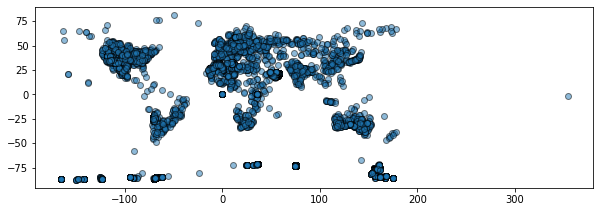

In [5]:
%matplotlib inline

#Let's do a simple view of the dataframe, just to see if everything is in order
ax = gpandas_meteorites.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

## Area Filtering

We have almost 40K points so it will be hard to add to them labels or to do similar operations. A good course of action is to find a way of determing a study zona. A zone in which we would like to have more details.

For this I see 2 possible approaches:

    - Load a polygon (or set of polygons) and filter the geoDataFrame by one of those.
    - Determine an area by setting a point (lat, long) and a radius.

In [6]:
##Filtering center point
LOCATION_NAME = "my_spot"
LATITUD = 36.980728
LONGITUD = -85.916985
#0.01 - 1km aprox
#0.1 - 10km aprox
RADIUS = 1.0 #point radius for filtering meteorite data.

##Turn the center point into a geopandas dataframe
location_point = pd.DataFrame({'point_name': [LOCATION_NAME], 'latitud': [LATITUD], 'longitud': [LONGITUD]})
#Set up geodataframe
crs = {'init':'epsg:3857'}
gpandas_point = geopandas.GeoDataFrame(location_point, crs = crs, 
                                       geometry=geopandas.points_from_xy(location_point.longitud, 
                                                                         location_point.latitud))

##Lets create a circle of the given radius.
circle_gdf = gpandas_point.copy()
#The distance varies with the crs (coordinates format)
circle_gdf['geometry'] = circle_gdf['geometry'].buffer(RADIUS)
    
#[Debug]
if DEBUG:
    print(gpandas_point)

  point_name    latitud   longitud                geometry
0    my_spot  36.980728 -85.916985  POINT (-85.917 36.981)


C:\Users\Fernando\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### A simple point and circle preview

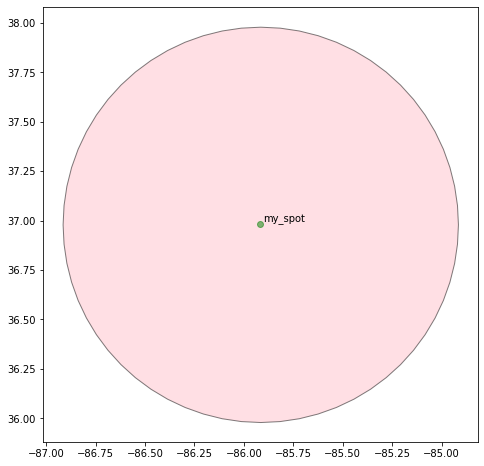

In [7]:
%matplotlib inline

#Crea el gráfico y agrega el geopandas del círculo.
ax = circle_gdf.plot(figsize=(10, 8), alpha=0.5, edgecolor='k', color = "pink")

#Agrega el geopandas con los puntos de Sitios.
gpandas_point.plot(ax = ax, alpha=0.5, color = "green")
#Toma cada punto y le agrega una label con la sigla de Sitio.
for x, y, label in zip(gpandas_point.geometry.x, gpandas_point.geometry.y, gpandas_point.point_name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")


## <font color='B43F26'> SJoin (Spatial Join)</font>
***

<i><font color='8a8a8a'>Does an spatila join between the points circle and the meteorits dataframe.</font></i><br>

In [8]:
within_points = geopandas.sjoin(gpandas_meteorites, circle_gdf, op = 'within')

#Drop columns refering to the center point information.
within_points = within_points.drop(columns=['index_right','point_name','latitud','longitud'])
if DEBUG:
    print(within_points.head(2))

C:\Users\Fernando\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


                name    id nametype     recclass   mass   fall  year  \
257      Drake Creek  7728    Valid           L6   5000   Fell  1827   
5326  Campbellsville  5245    Valid  Iron, IIIAB  15400  Found  1929   

         reclat     reclong              GeoLocation                geometry  
257   36.400000  -86.500000  (36.400000, -86.500000)  POINT (-86.500 36.400)  
5326  37.366670  -85.366670  (37.366670, -85.366670)  POINT (-85.367 37.367)  


#### Let's show once again a Map but this time been the final resulta

We'll show the center point in green, de circle area in pink and the meteorits, within that area, in blue.

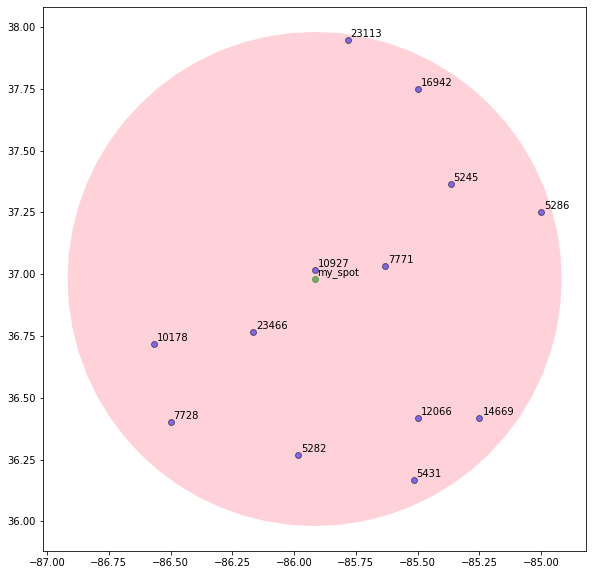

In [10]:
%matplotlib inline

#Creates the graph based on the circle area.
ax = circle_gdf.plot(figsize=(10, 10), alpha=0.7, color='pink')

#Creates the graph based on the meteorite in that area.
within_points.plot(ax=ax, alpha=0.5, edgecolor='k', color='blue')
#Takes each meteorite location point and adds a label to it.
for x, y, label in zip(within_points.geometry.x, within_points.geometry.y, within_points.id):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

#Adds the circle center point
gpandas_point.plot(ax=ax, alpha=0.5, color = "green")
#Takes each location point and adds a label to it.
for x, y, label in zip(gpandas_point.geometry.x, gpandas_point.geometry.y, gpandas_point.point_name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## <font color='B43F26'> KML and Export</font>
***

<i><font color='8a8a8a'>I build a simple kml and an export link in order to have an other option of visualizarion/testing.
The file can be as complex as you like. For this example I keept it simple.</font></i><br>

In [11]:
#points_style = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
points_style = 'http://maps.google.com/mapfiles/kml/shapes/shaded_dot.png'
points_size = '0.8'
points_color = {
    '_stile_1': 'ffF06E14'
    #<name>: <color>
}

def set_points_format(f_stream):
    #Points format
    for keys in points_color:
        f_stream.write("<Style id= '" + keys + "' >\n")
        f_stream.write("   <IconStyle>\n")
        f_stream.write("       <scale>" + points_size + "</scale>\n")
        f_stream.write("       <color>" + points_color[keys] + "</color>\n")
        f_stream.write("       <Icon><href>" + points_style + "</href></Icon>\n")
        f_stream.write("       <hotSpot x='20' y='2' xunits='pixels' yunits='pixels'/>\n")
        f_stream.write("   </IconStyle>\n")
        f_stream.write("   <LabelStyle>\n")
        f_stream.write("       <color>" + points_color[keys] + "</color>\n")
        f_stream.write("   </LabelStyle>\n")
        f_stream.write("</Style>\n")
    return

def print_points_info(pint_row):
    col_list = ["reclat","reclong","id","name","year","mass", "fall"]
    for name, value in row.iteritems():
        if str(name) in col_list:
            f.write("               <tr><td>" + str(name) + "</td><td>" + str(value) + "</td></tr>\n")
    return

#Opens a strem to the file we want to create.
f = open('geo2kml.kml', 'w')
fname = 'geo2kml'
#Kml file construction.
f.write("<?xml version='1.0' encoding='UTF-8'?>\n")
f.write("<kml xmlns='http://earth.google.com/kml/2.1'>\n")
f.write("<Document>\n")
f.write("   <name>" + fname + '.kml' +"</name>\n")
#Points format
set_points_format(f)
for index, row in within_points.iterrows():
    f.write("   <Placemark>\n")
    #Disables the points visualization during kml opening(for big files or slow PCs)
    f.write("       <visibility>0</visibility>\n")
    #Point name
    #f.write("       <name>" + str(row.id_unico) + "</name>\n")
    #Point color
    f.write("       <styleUrl>#_stile_1</styleUrl>\n")
    f.write("       <snippet maxLines='2'></snippet>\n")
    #Point general description and info
    f.write("       <description>\n")
    f.write("           <![CDATA[\n")
    f.write("               <table border='1' padding='3' widhth='500px'>\n")
    print_points_info(row)
    f.write("               </table>\n")
    f.write("           ]]>\n")
    f.write("       </description>\n")
    #Point coordinates
    f.write("       <Point>\n")
    f.write("           <coordinates>" + str(row.reclong) + "," + str(row.reclat) + "</coordinates>\n")
    f.write("       </Point>\n")
    f.write("   </Placemark>\n")
f.write("</Document>\n")
f.write("</kml>\n")
f.close()

print("File Created.")
#Generate the link for a direct download/openning
FileLink('geo2kml.kml')

File Created.


D:\BDyA\JupyterLab\interaction_with_geolocated_measures\geo2kml.kml